This cell installs the sympy library, which is used to generate cryptographically secure prime numbers.


In [ ]:
!pip install sympy

**Generate Primes**

This cell defines a function to generate a list of prime numbers of specified bit length and displays them along with their bit lengths.

In [ ]:
from sympy import randprime

# Function to generate primes
def generate_primes(count, bits):
    lower = 2**(bits - 1)
    upper = 2**bits - 1
    primes = [randprime(lower, upper) for _ in range(count)]
    return primes

# Example usage
num_primes = 5    # Number of primes
bit_length = 512  # Bit length of each prime

primes = generate_primes(num_primes, bit_length)

# Display generated primes
for i, p in enumerate(primes):
    print(f"Prime {i+1}:\n{p}\n")

# Display bit length of each prime
for i, p in enumerate(primes):
    print(f"Prime {i+1} has {p.bit_length()} bits")


Prime 1:
9040837347252222795007968044011690957539865918721736472811731533143928750736963061378144494244556863762487121226229154764544716515486842654086359413585831

Prime 2:
11996791937515494361766161404765837918843163690239771585685613900735658255684165816297773176590518602267683032179469135419318860809395893536548495355287637

Prime 3:
8923467872542516765886762448229888377759506066876193777065365935762892128156390296286128722179989864614176189352416842218315859605471184697739278540337711

Prime 4:
8852469101974510446947498241289955474650961742740122815276740816617272108524151030779944506066424489102993514784887245857475833938586614327602748590016417

Prime 5:
8020457168746923915356383974955365424762351922715149243575888658302591786290169370030203268948514559638692749279910626361851661987835373848800655209082511

Prime 1 has 512 bits
Prime 2 has 512 bits
Prime 3 has 512 bits
Prime 4 has 512 bits
Prime 5 has 512 bits


**Key Generation for Alice and Bob**

This cell generates private and public keys for Alice and Bob using the generated primes and displays their public keys.

In [ ]:
import secrets

# Function to generate private and public keys
def generate_keys(primes):
    private_keys = []
    public_keys = []
    for p in primes:
        g = 2  # Using 2 as the generator
        private = secrets.randbelow(p - 2) + 1  # Random private key: 1 < key < p-1
        public = pow(g, private, p)  # Compute public key
        private_keys.append(private)
        public_keys.append(public)
    return private_keys, public_keys

# Example: Generate keys for Alice and Bob
alice_private, alice_public = generate_keys(primes)
bob_private, bob_public = generate_keys(primes)

# Display Alice's public keys
print("Alice's Public Keys:")
for i, key in enumerate(alice_public):
    print(f"Prime {i+1}: {key}")

# Display Bob's public keys
print("\nBob's Public Keys:")
for i, key in enumerate(bob_public):
    print(f"Prime {i+1}: {key}")


Alice's Public Keys:
Prime 1: 3595656241200604840821768180805583075946069750554269939180657750458151802416139280214322273436354213079961608072012050206931676013609005518380276744259148
Prime 2: 2667139517768517767854702719806093587611602247044003548289036288795927088388703353803349378046252389981581833884825015589603395501582619554788464733226267
Prime 3: 3920393486594660059538217210226534920376617583433064440210378298263761001726329086752801222482272007415725741577083968708306043902672303473416670960977914
Prime 4: 3966199173542262053587680877887592035061016788608484746831990297607519242802725224619678635702326916053553298965929381362247806886746649187004327947470404
Prime 5: 6465332073642779418015049322083307010656586771925605249934578007936162938493197283502545389487381099956678576297923127424325795428977563919804538689099687

Bob's Public Keys:
Prime 1: 1513740057590727909106882806214258186100182919399219785761823822896213873093365308789258852266387291647297389139463467215354324669

**Compute Shared Keys**

This cell computes the shared keys for Alice and Bob using each prime and displays the length of each shared key.

In [ ]:
# Function to compute shared keys
def compute_shared_keys(private_keys, other_public_keys, primes):
    shared_keys = []
    for i in range(len(primes)):
        key = pow(other_public_keys[i], private_keys[i], primes[i])
        # Convert to bytes for later combination
        key_bytes = key.to_bytes((key.bit_length() + 7) // 8, 'big')
        shared_keys.append(key_bytes)
    return shared_keys

# Compute shared keys
alice_shared = compute_shared_keys(alice_private, bob_public, primes)
bob_shared = compute_shared_keys(bob_private, alice_public, primes)

# Verify that each key matches in length (they will be combined later)
for i in range(len(primes)):
    print(f"Shared Key {i+1} length: {len(alice_shared[i])} bytes")


Shared Key 1 length: 64 bytes
Shared Key 2 length: 64 bytes
Shared Key 3 length: 64 bytes
Shared Key 4 length: 64 bytes
Shared Key 5 length: 64 bytes


**Combine Shared Keys**

This cell concatenates the shared keys and applies SHA-256 hashing to derive the final shared secret key for both Alice and Bob, and verifies that both keys match.

In [ ]:
import hashlib

# Function to combine shared keys
def combine_shared_keys(shared_keys_list):
    combined = b''.join(shared_keys_list)  # Concatenate all keys
    final_key = hashlib.sha256(combined).hexdigest()  # Hash with SHA-256
    return final_key

# Combine Alice's and Bob's shared keys
alice_final_key = combine_shared_keys(alice_shared)
bob_final_key = combine_shared_keys(bob_shared)

# Verify that both are identical
print("Alice's Final Key:", alice_final_key)
print("Bob's Final Key  :", bob_final_key)
print("Keys Match?      :", alice_final_key == bob_final_key)


Alice's Final Key: 9b3345e8d63e21f5bcf5e9c6ecaedb96474bbe444bfa5835b24c8d326eec9d73
Bob's Final Key  : 9b3345e8d63e21f5bcf5e9c6ecaedb96474bbe444bfa5835b24c8d326eec9d73
Keys Match?      : True


**Benchmarking Multi-Prime vs Single-Prime**

This cell compares the execution time of multi-prime Diffie-Hellman against single-prime Diffie-Hellman using equivalent total bits.

In [ ]:
import time
from sympy import nextprime

# Function for single-prime Diffie-Hellman
def single_prime_dh(total_bits):
    p = nextprime(2**(total_bits-1))  # Large single prime
    g = 2
    # Random private keys
    alice_private = secrets.randbelow(p - 2) + 1
    bob_private   = secrets.randbelow(p - 2) + 1
    # Public keys
    alice_public = pow(g, alice_private, p)
    bob_public   = pow(g, bob_private, p)
    # Shared secret
    alice_shared = pow(bob_public, alice_private, p)
    bob_shared   = pow(alice_public, bob_private, p)
    return alice_shared == bob_shared  # Returns True if keys match

# Multi-prime timing
start = time.time()
# Reuse multi-prime code from Module 3
alice_private, alice_public = generate_keys(primes)
bob_private, bob_public = generate_keys(primes)
alice_shared = compute_shared_keys(alice_private, bob_public, primes)
bob_shared   = compute_shared_keys(bob_private, alice_public, primes)
alice_final_key = combine_shared_keys(alice_shared)
bob_final_key   = combine_shared_keys(bob_shared)
end = time.time()
multi_time = end - start
print("Multi-Prime DH Execution Time:", multi_time, "seconds")

# Single-prime timing
total_bits = 512 * len(primes)  # Same total bits as multi-prime
start = time.time()
single_prime_dh(total_bits)
end = time.time()
single_time = end - start
print("Single-Prime DH Execution Time:", single_time, "seconds")


Multi-Prime DH Execution Time: 0.018764495849609375 seconds
Single-Prime DH Execution Time: 15.303901672363281 seconds


**Plotting the Performance Comparison**

This cell visualizes the execution time of the two methods using a bar chart for easier comparison.

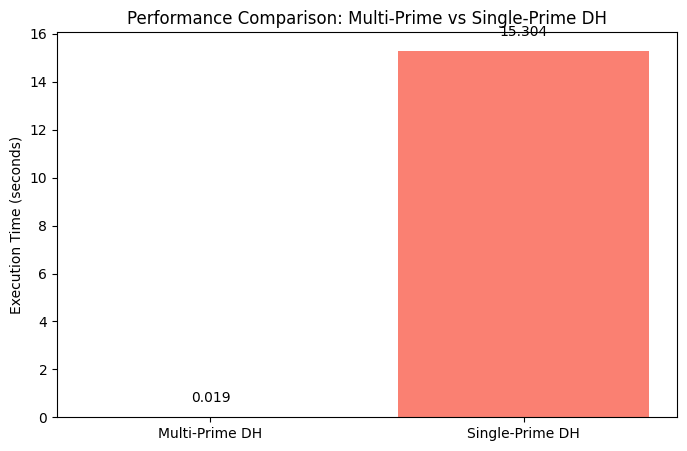

In [ ]:
import matplotlib.pyplot as plt

# Data
methods = ['Multi-Prime DH', 'Single-Prime DH']
times = [multi_time, single_time]

# Plot
plt.figure(figsize=(8,5))
bars = plt.bar(methods, times, color=['skyblue', 'salmon'])
plt.ylabel("Execution Time (seconds)")
plt.title("Performance Comparison: Multi-Prime vs Single-Prime DH")

# Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f"{yval:.3f}", ha='center', va='bottom')

plt.show()


**Simulating Network Exchange**

This cell simulates how Alice and Bob exchange public keys over a network and verifies that both sides compute the same final shared key.

In [ ]:
# Simulate network exchange
def network_exchange(alice_pub, bob_pub):
    # Normally, these would be sent over a network
    alice_received = bob_pub
    bob_received   = alice_pub
    return alice_received, bob_received

# Simulate exchange
alice_received, bob_received = network_exchange(alice_public, bob_public)

# Compute shared keys using received keys
alice_shared_network = compute_shared_keys(alice_private, alice_received, primes)
bob_shared_network   = compute_shared_keys(bob_private, bob_received, primes)

# Combine to final shared secret
alice_final_network = combine_shared_keys(alice_shared_network)
bob_final_network   = combine_shared_keys(bob_shared_network)

print("Final Shared Key (Network Simulation):")
print(alice_final_network)
print("Keys Match? :", alice_final_network == bob_final_network)


Final Shared Key (Network Simulation):
25a2e16fec3203b40cc0a22a2fa7833dba858762ba57c7b328c2181f4d284679
Keys Match? : True


**Encrypt/Decrypt Message**

This cell demonstrates how the shared key can be used to encrypt and decrypt a message using AES encryption.

In [ ]:
!pip install pycryptodome


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 15.1 MB/s eta 0:00:00


In [ ]:
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
import hashlib

# Derive AES key from shared secret (use 32 bytes for AES-256)
aes_key = hashlib.sha256(alice_final_network.encode()).digest()

# Example message
message = b"Hello, this is a secret message!"

# Encrypt
cipher = AES.new(aes_key, AES.MODE_CBC)
ct_bytes = cipher.encrypt(pad(message, AES.block_size))
iv = cipher.iv

# Decrypt
cipher_dec = AES.new(aes_key, AES.MODE_CBC, iv)
pt = unpad(cipher_dec.decrypt(ct_bytes), AES.block_size)

print("Original Message:", message)
print("Decrypted Message:", pt)


Original Message: b'Hello, this is a secret message!'
Decrypted Message: b'Hello, this is a secret message!'


**Install Graphviz**

This cell installs graphviz to visualize the flow of the multi-prime Diffie-Hellman protocol.

In [ ]:
!apt-get install graphviz
!pip install graphviz


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


**Create Flowchart Diagram**

This cell creates and displays a flowchart that illustrates the stages of the multi-prime Diffie-Hellman process.

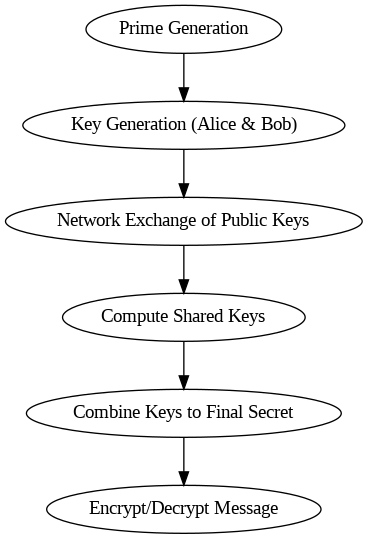

In [ ]:
from graphviz import Digraph

dot = Digraph(comment='Multi-Prime Diffie-Hellman')

# Nodes
dot.node('A', 'Prime Generation')
dot.node('B', 'Key Generation (Alice & Bob)')
dot.node('C', 'Network Exchange of Public Keys')
dot.node('D', 'Compute Shared Keys')
dot.node('E', 'Combine Keys to Final Secret')
dot.node('F', 'Encrypt/Decrypt Message')

# Edges
dot.edges(['AB', 'BC', 'CD', 'DE', 'EF'])

# Display the graph
dot.render('multi_prime_dh_flowchart', format='png', cleanup=True)
from IPython.display import Image
Image('multi_prime_dh_flowchart.png')


**Install ipywidgets**

This cell installs ipywidgets, which enables interactive UI elements in the notebook.

In [ ]:
!pip install ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.2 MB/s eta 0:00:00


**Interactive Demo Setup**

This cell defines a fully functional interactive demo where the user can select the number of primes and a message, and view the computed shared key, encrypted message, decrypted message, and whether the keys match.

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import hashlib
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad
import secrets

# Fixed interactive function
def interactive_demo_fixed(num_primes, message):
    # Generate primes
    primes = generate_primes(num_primes, 128)  # smaller primes for fast demo

    # Generate keys for Alice and Bob
    alice_private, alice_public = generate_keys(primes)
    bob_private, bob_public     = generate_keys(primes)

    # Compute shared keys correctly
    alice_shared = compute_shared_keys(alice_private, bob_public, primes)
    bob_shared   = compute_shared_keys(bob_private, alice_public, primes)

    # Combine to final shared secret
    alice_final = combine_shared_keys(alice_shared)
    bob_final   = combine_shared_keys(bob_shared)

    # AES encryption
    aes_key = hashlib.sha256(alice_final.encode()).digest()
    cipher = AES.new(aes_key, AES.MODE_CBC)
    ct_bytes = cipher.encrypt(pad(message.encode(), AES.block_size))
    cipher_dec = AES.new(aes_key, AES.MODE_CBC, cipher.iv)
    pt = unpad(cipher_dec.decrypt(ct_bytes), AES.block_size)

    # Print outputs
    print("=====================================")
    print(f"Number of Primes: {num_primes}")
    print(f"Final Shared Key: {alice_final}")
    print(f"Encrypted Message (hex): {ct_bytes.hex()}")
    print(f"Decrypted Message: {pt.decode()}")
    print("Keys Match? :", alice_final == bob_final)
    print("=====================================")


display(ui, out)


Output()

In [1]:
!jupyter nbextension disable --py widgetsnbextension


Disabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
